In [2]:
#Imports 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

#two choices for lightgbm
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier


In [3]:
#datas
df=pd.read_csv('cleaned_data.csv')
df

,MIS_Status,LoanNr_ChkDgt,State,Zip,UrbanRural,Bank,BankState,NAICS,NoEmp,NewExist,...,FranchiseCode,IsFranchise,Term,RevLineCr,LowDoc,DisbursementGross,ApprovalDate,ApprovalFY,GrAppv,SBA_Appv
0,1,1000014003,IN,47711,0,FIFTH THIRD BANK,OH,451120,4,2.0,...,1,1,84,0,1,60000.0,1997-02-28,1997,60000.0,48000.0
1,1,1000024006,IN,46526,0,1ST SOURCE BANK,IN,722410,2,2.0,...,1,1,60,0,1,40000.0,1997-02-28,1997,40000.0,32000.0
2,1,1000034009,IN,47401,0,GRANT COUNTY STATE BANK,IN,621210,7,1.0,...,1,1,180,0,0,287000.0,1997-02-28,1997,287000.0,215250.0
3,1,1000044001,OK,74012,0,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,...,1,1,60,0,1,35000.0,1997-02-28,1997,35000.0,28000.0
4,1,1000054004,FL,32801,0,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,...,1,1,240,0,0,229000.0,1997-02-28,1997,229000.0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,1,9995573004,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,6,1.0,...,1,1,60,0,0,70000.0,1997-02-27,1997,70000.0,56000.0
899160,1,9995603000,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,6,1.0,...,1,1,60,0,0,85000.0,1997-02-27,1997,85000.0,42500.0
899161,1,9995613003,CA,93455,0,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,26,1.0,...,1,1,108,0,0,300000.0,1997-02-27,1997,300000.0,225000.0
899162,0,9995973006,HI,96830,0,BANK OF HAWAII,HI,0,6,1.0,...,1,1,60,0,1,75000.0,1997-02-27,1997,75000.0,60000.0


### First test based on interactive doc

In [25]:
#Encoding categorical values with LabelEncoder
label_encoders = {}
categorical_cols = ['Zip', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'MIS_Status']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  #Conversion in str type to avoid mistakes
    label_encoders[col] = le  # Stock the encoder if needed after for the prediction

#Selection of valuable features
features = ['Zip', 'NAICS', 'ApprovalFY', 'NewExist', 'CreateJob', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc']


X = df[features] 
y = df['MIS_Status'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Logistic regression 
model = LogisticRegression(max_iter=100, solver='lbfgs')
model.fit(X_train, y_train)

#Predictions and values
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

#Result
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8245
Confusion Matrix:
[[     0  31564]
 [     1 148268]]


# Test avec LightGBM

#### Test avec HistGradientBoostingClassifier (from sklearn)

In [29]:
df.columns

Index(['MIS_Status', 'LoanNr_ChkDgt', 'State', 'Zip', 'UrbanRural', 'Bank',
       'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'IsFranchise', 'Term', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'ApprovalDate', 'ApprovalFY', 'GrAppv',
       'SBA_Appv'],
      dtype='object')

In [85]:
#Test with HistGradientBoostRegressor
features = ['State','Zip','UrbanRural','Bank','BankState','NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'IsFranchise', 'Term', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'ApprovalDate', 'ApprovalFY', 'GrAppv']

X = df[features]
y = df['MIS_Status']

label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']

for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X['ApprovalDate']=pd.to_datetime(X['ApprovalDate'])
X['ApprovalDate']=X["ApprovalDate"].dt.year


cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 
            'IsFranchise', 'RevLineCr', 'LowDoc']

for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = HistGradientBoostingClassifier(max_bins=255, max_iter=100, categorical_features="from_dtype")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')


/tmp/ipykernel_70556/2860251282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/2860251282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/2860251282.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

Accuracy: 0.948


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
# Assuming y_true are the actual labels and y_pred are the predicted labels
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)  # Convert probabilities to class labels (for binary classification)

# Metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')  # 'weighted' for multi-class
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.9479
Precision: 0.9469
Recall: 0.9479
F1 Score: 0.9471
ROC AUC Score: 0.8958733842725979


In [73]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/2726703298.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


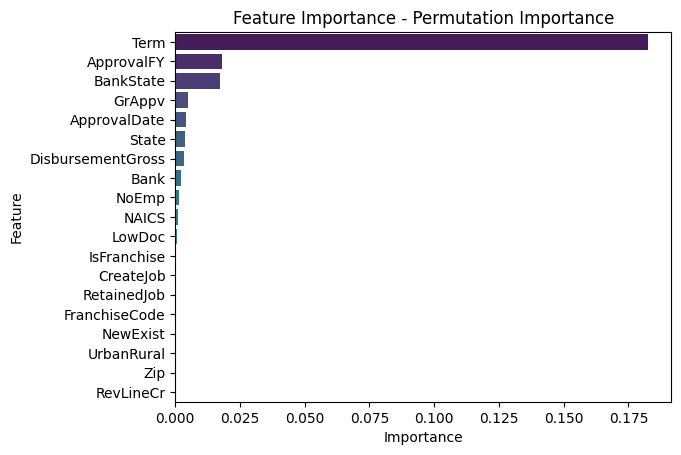

In [87]:
# Calcul de l'importance des features par permutation
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Extraire les importances moyennes
importances = result.importances_mean

# Créer un DataFrame pour affichage
features_names = X_test.columns
importance_df = pd.DataFrame({"Feature": features_names, "Importance": importances})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot avec Seaborn
#plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Importance")
plt.show()

### Test avec LGBM Classifier

In [88]:
#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Label encoding
label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']
for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=100, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_70556/3267484716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/3267484716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/3267484716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc, categorical_column=0,2,4,7,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2485
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
Accuracy: 0.9491
Precision: 0.9481
Recall: 0.9491
F1 Score: 0.9484
ROC AUC Score: 0.8989256495416058


In [89]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/2487718227.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


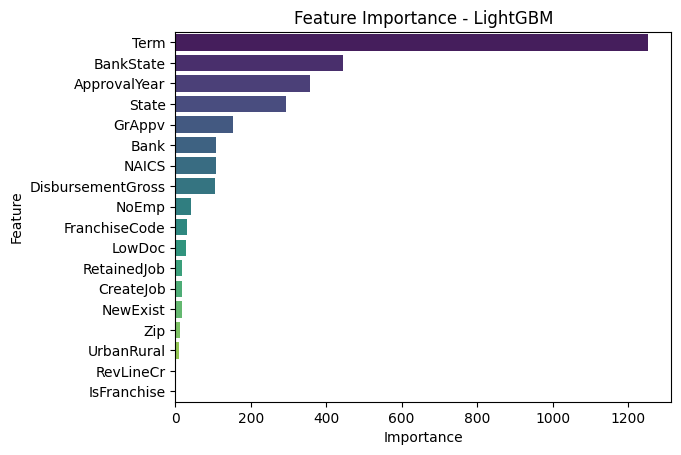

In [90]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()


In [ ]:
#Test with categorisation of NAICS

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Label encoding
label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']
for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=100, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_70556/613333879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/613333879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/613333879.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS, categorical_column=0,2,4,5,7,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3106
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> i

In [93]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/3609398526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


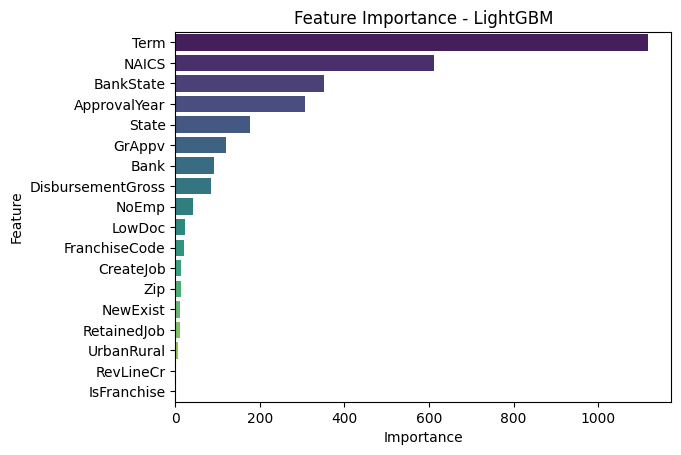

In [94]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()

In [4]:
#Test with categorisation of all

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=100, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/2357742612.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/2357742612.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/2357742612.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightG

In [5]:
print(classification_report(y_test, y_pred_labels))

NameError: name 'y_pred_labels' is not defined

#### Fine tunning

In [6]:
#Gridsearch

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)

param_grid = {
    'n_estimators':[100, 150, 200],
    'learning_rate':[0.1, 0.2, 0.3]
}
grid=GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)


grid.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Result
print(f'best parameters : {grid.best_params_}')
print(f'best score : {grid.best_score_}')
print(f'Score on the entire test : {grid.score(X_test, y_test)}')

/tmp/ipykernel_117114/3924234536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/3924234536.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/3924234536.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in pa

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For cat

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.741875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode[LightGBM] [Info] Number of data points in the train set: 64739

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.622195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.532506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.549782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.639922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.597582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.580316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.585147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.482046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.545647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.536505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.442416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.540455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.509878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.444263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.662998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.546916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.537476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.578748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.578128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.548356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.566368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.570515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18283
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.646146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18292
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightG

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 533768, number of negative: 113629


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.607225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18306
[LightGBM] [Info] Number of data points in the train set: 647397, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547023
[LightGBM] [Info] Start training from score 1.547023
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.589947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18209
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824482 -> initscore=1.547014
[LightGBM] [Info] Start training from score 1.547014
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.457410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18262
[LightGBM] [Info] Number of data points in the train set: 647398, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824482 -> initscore=1.547014
[LightGBM] [Info] Start training from score 1.547014
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFran

/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1

In [ ]:
#Test with n_estimators = 200

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=200, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/1621750461.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/1621750461.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/1621750461.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.93      0.91      0.92     89917
weighted avg       0.95      0.95      0.95     89917



In [13]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print(f'Best parameters: {study.best_params}')


/home/utilisateur/Documents/accord_pret/loan_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-07 15:49:18,580] A new study created in memory with name: no-name-695dcc10-ded5-497f-889f-8f63aae22821
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:49:39,900] Trial 0 finished with value: 0.9061530451272262 and parameters: {'n_estimators': 369, 'learning_rate': 0.027846365856069682, 'num_leaves': 57, 'max_depth': 13, 'subsample': 0.7155995485562359, 'colsample_bytree': 0.6547798599699056}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:49:44,944] Trial 1 finished with value: 0.889944900103596 and parameters: {'n_estimators': 192, 'learning_rate': 0.10756666711765574, 'num_leaves': 99, 'max_depth': 4, 'subsample': 0.7994622046946344, 'colsample_bytree': 0.7308029048333204}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:49:58,656] Trial 2 finished with value: 0.8999509789999145 and parameters: {'n_estimators': 273, 'learning_rate': 0.028325523257323584, 'num_leaves': 85, 'max_depth': 7, 'subsample': 0.8920788260566317, 'colsample_bytree': 0.8464725454369817}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:50:01,856] Trial 3 finished with value: 0.8011952912045012 and parameters: {'n_estimators': 111, 'learning_rate': 0.02595003079633617, 'num_leaves': 31, 'max_depth': 3, 'subsample': 0.8172880535666214, 'colsample_bytree': 0.8108175090949852}. Best is trial 0 with value: 0.9061530451272262.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 15:50:15,782] Trial 4 finished with value: 0.8775264836434801 and parameters: {'n_estimators': 477, 'learning_rate': 0.01998390341274766, 'num_leaves': 36, 'max_depth': 4, 'subsample': 0.6284383549158045, 'colsample_bytree': 0.864412376776055}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:50:41,165] Trial 5 finished with value: 0.9037857054816741 and parameters: {'n_estimators': 366, 'learning_rate': 0.014022151200024004, 'num_leaves': 81, 'max_depth': 13, 'subsample': 0.8416506860569266, 'colsample_bytree': 0.7538343389498017}. Best is trial 0 with value: 0.9061530451272262.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:02,650] Trial 6 finished with value: 0.9078812523676845 and parameters: {'n_estimators': 389, 'learning_rate': 0.03620006935517644, 'num_leaves': 46, 'max_depth': 14, 'subsample': 0.9880537596838941, 'colsample_bytree': 0.8921122280040867}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:10,765] Trial 7 finished with value: 0.879607270374698 and parameters: {'n_estimators': 174, 'learning_rate': 0.0208860561049388, 'num_leaves': 28, 'max_depth': 12, 'subsample': 0.9770918998958311, 'colsample_bytree': 0.6900472712887183}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:25,401] Trial 8 finished with value: 0.9061853494402135 and parameters: {'n_estimators': 321, 'learning_rate': 0.05976352199500926, 'num_leaves': 40, 'max_depth': 9, 'subsample': 0.9814002378709473, 'colsample_bytree': 0.7698498085526126}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-07 15:51:31,259] Trial 9 finished with value: 0.7159230318546457 and parameters: {'n_estimators': 444, 'learning_rate': 0.011984083013070917, 'num_leaves': 55, 'max_depth': 1, 'subsample': 0.6819961887704549, 'colsample_bytree': 0.7397680460483115}. Best is trial 6 with value: 0.9078812523676845.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:51:57,150] Trial 10 finished with value: 0.9113969489723392 and parameters: {'n_estimators': 411, 'learning_rate': 0.20465056780875407, 'num_leaves': 70, 'max_depth': 15, 'subsample': 0.8979799251170678, 'colsample_bytree': 0.996066133773424}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:52:23,352] Trial 11 finished with value: 0.9109654766501125 and parameters: {'n_estimators': 414, 'learning_rate': 0.25779175941732074, 'num_leaves': 71, 'max_depth': 15, 'subsample': 0.9217013608450743, 'colsample_bytree': 0.9958679594214387}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:52:49,919] Trial 12 finished with value: 0.9107664289709346 and parameters: {'n_estimators': 433, 'learning_rate': 0.2846371441575327, 'num_leaves': 73, 'max_depth': 15, 'subsample': 0.8981202879508426, 'colsample_bytree': 0.9902052318166449}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:11,508] Trial 13 finished with value: 0.910542789381358 and parameters: {'n_estimators': 486, 'learning_rate': 0.2786861955963915, 'num_leaves': 69, 'max_depth': 10, 'subsample': 0.9050304692558299, 'colsample_bytree': 0.9961324670999517}. Best is trial 10 with value: 0.9113969489723392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:25,416] Trial 14 finished with value: 0.9116532381744706 and parameters: {'n_estimators': 301, 'learning_rate': 0.14834026171386322, 'num_leaves': 65, 'max_depth': 10, 'subsample': 0.9288688291454804, 'colsample_bytree': 0.9246766702374872}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:38,129] Trial 15 finished with value: 0.910472231602813 and parameters: {'n_estimators': 279, 'learning_rate': 0.1626599791154231, 'num_leaves': 92, 'max_depth': 10, 'subsample': 0.7605614212632557, 'colsample_bytree': 0.9347126294180422}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:53:50,434] Trial 16 finished with value: 0.9098340671476205 and parameters: {'n_estimators': 318, 'learning_rate': 0.10574712416945142, 'num_leaves': 62, 'max_depth': 8, 'subsample': 0.8448776887858758, 'colsample_bytree': 0.9293854768439762}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:01,399] Trial 17 finished with value: 0.9115271341741896 and parameters: {'n_estimators': 241, 'learning_rate': 0.15331909668203703, 'num_leaves': 49, 'max_depth': 11, 'subsample': 0.9359108752745865, 'colsample_bytree': 0.9315171949716097}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:10,003] Trial 18 finished with value: 0.903917135984192 and parameters: {'n_estimators': 226, 'learning_rate': 0.0772775133204462, 'num_leaves': 49, 'max_depth': 7, 'subsample': 0.9460311384626422, 'colsample_bytree': 0.9228857963670261}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:19,102] Trial 19 finished with value: 0.9061657387324841 and parameters: {'n_estimators': 245, 'learning_rate': 0.1390001720670246, 'num_leaves': 20, 'max_depth': 11, 'subsample': 0.8567008214368003, 'colsample_bytree': 0.8056140786592534}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 15:54:25,188] Trial 20 finished with value: 0.8901924042522549 and parameters: {'n_estimators': 141, 'learning_rate': 0.04562310461435059, 'num_leaves': 48, 'max_depth': 6, 'subsample': 0.9556569281809866, 'colsample_bytree': 0.9508170932050328}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:41,279] Trial 21 finished with value: 0.9116011505039703 and parameters: {'n_estimators': 333, 'learning_rate': 0.1976511931598284, 'num_leaves': 65, 'max_depth': 12, 'subsample': 0.8750082173148346, 'colsample_bytree': 0.879906784892601}. Best is trial 14 with value: 0.9116532381744706.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:54:56,440] Trial 22 finished with value: 0.913381445414929 and parameters: {'n_estimators': 340, 'learning_rate': 0.14597293005490072, 'num_leaves': 58, 'max_depth': 11, 'subsample': 0.935087518878086, 'colsample_bytree': 0.8869899242998047}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:55:13,184] Trial 23 finished with value: 0.912292370579564 and parameters: {'n_estimators': 347, 'learning_rate': 0.09373043639193333, 'num_leaves': 62, 'max_depth': 12, 'subsample': 0.8633848321139715, 'colsample_bytree': 0.8607907780561214}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:55:29,013] Trial 24 finished with value: 0.9117625673679243 and parameters: {'n_estimators': 351, 'learning_rate': 0.09006237943602878, 'num_leaves': 79, 'max_depth': 10, 'subsample': 0.7794581384796194, 'colsample_bytree': 0.8298134413182894}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:55:43,865] Trial 25 finished with value: 0.9111512080736986 and parameters: {'n_estimators': 354, 'learning_rate': 0.08090374800667269, 'num_leaves': 81, 'max_depth': 9, 'subsample': 0.76972697068283, 'colsample_bytree': 0.8353306956280316}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:56:14,743] Trial 26 finished with value: 0.912183664036444 and parameters: {'n_estimators': 343, 'learning_rate': 0.10397151872392994, 'num_leaves': 77, 'max_depth': -1, 'subsample': 0.7387193705586924, 'colsample_bytree': 0.8304335214828878}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:56:36,067] Trial 27 finished with value: 0.911308648437066 and parameters: {'n_estimators': 274, 'learning_rate': 0.06943232506223021, 'num_leaves': 56, 'max_depth': -1, 'subsample': 0.7293403811298976, 'colsample_bytree': 0.8924191758973675}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:57:15,066] Trial 28 finished with value: 0.9125241725722794 and parameters: {'n_estimators': 390, 'learning_rate': 0.04753989529233664, 'num_leaves': 87, 'max_depth': -1, 'subsample': 0.6458454297932384, 'colsample_bytree': 0.7936620799138767}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:57:34,579] Trial 29 finished with value: 0.9128540281036412 and parameters: {'n_estimators': 382, 'learning_rate': 0.050944558429102976, 'num_leaves': 90, 'max_depth': 13, 'subsample': 0.6071700113515591, 'colsample_bytree': 0.6567085998300766}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 15:57:42,601] Trial 30 finished with value: 0.8529612288329549 and parameters: {'n_estimators': 395, 'learning_rate': 0.04619467763539976, 'num_leaves': 92, 'max_depth': 2, 'subsample': 0.6241822466255337, 'colsample_bytree': 0.609065753883025}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:58:03,124] Trial 31 finished with value: 0.9126228487612597 and parameters: {'n_estimators': 380, 'learning_rate': 0.04752963822892663, 'num_leaves': 90, 'max_depth': 13, 'subsample': 0.6020241782875259, 'colsample_bytree': 0.6871004995908109}. Best is trial 22 with value: 0.913381445414929.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:58:23,259] Trial 32 finished with value: 0.9135982358508352 and parameters: {'n_estimators': 378, 'learning_rate': 0.04994671054490809, 'num_leaves': 99, 'max_depth': 13, 'subsample': 0.6608879132638167, 'colsample_bytree': 0.6939594218797047}. Best is trial 32 with value: 0.9135982358508352.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:58:49,060] Trial 33 finished with value: 0.9122379649575126 and parameters: {'n_estimators': 462, 'learning_rate': 0.03512319814232804, 'num_leaves': 100, 'max_depth': 13, 'subsample': 0.6673352770119606, 'colsample_bytree': 0.6903592294704635}. Best is trial 32 with value: 0.9135982358508352.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:59:07,631] Trial 34 finished with value: 0.9134269612825253 and parameters: {'n_estimators': 376, 'learning_rate': 0.05876572668097509, 'num_leaves': 94, 'max_depth': 13, 'subsample': 0.6065182868994656, 'colsample_bytree': 0.6308567232459344}. Best is trial 32 with value: 0.9135982358508352.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:59:30,547] Trial 35 finished with value: 0.9154263645809413 and parameters: {'n_estimators': 420, 'learning_rate': 0.06224037175185122, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6996041312359067, 'colsample_bytree': 0.6113657142402763}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 15:59:54,049] Trial 36 finished with value: 0.9147320312536793 and parameters: {'n_estimators': 429, 'learning_rate': 0.06395251190040667, 'num_leaves': 95, 'max_depth': 14, 'subsample': 0.6934170224307954, 'colsample_bytree': 0.6079950633204748}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:00:20,343] Trial 37 finished with value: 0.9123552839043214 and parameters: {'n_estimators': 447, 'learning_rate': 0.03480848633522244, 'num_leaves': 96, 'max_depth': 14, 'subsample': 0.6970887457542719, 'colsample_bytree': 0.6003347356054602}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:00:46,847] Trial 38 finished with value: 0.9149544255425884 and parameters: {'n_estimators': 496, 'learning_rate': 0.05912060947141281, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.6597655147113297, 'colsample_bytree': 0.6223428667827811}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:01:11,672] Trial 39 finished with value: 0.9100876930986335 and parameters: {'n_estimators': 422, 'learning_rate': 0.027691710085276437, 'num_leaves': 85, 'max_depth': 14, 'subsample': 0.7080730159670984, 'colsample_bytree': 0.6512634200106996}. Best is trial 35 with value: 0.9154263645809413.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:01:39,456] Trial 40 finished with value: 0.9160970059989049 and parameters: {'n_estimators': 492, 'learning_rate': 0.0677304401558715, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6590550923788405, 'colsample_bytree': 0.7135574824658621}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:02:04,413] Trial 41 finished with value: 0.9151788604322825 and parameters: {'n_estimators': 493, 'learning_rate': 0.0683184763502626, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6532189074310315, 'colsample_bytree': 0.627735560734268}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:02:30,124] Trial 42 finished with value: 0.9153393093463353 and parameters: {'n_estimators': 489, 'learning_rate': 0.06301129710566539, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.6809577096352131, 'colsample_bytree': 0.6294931987632033}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:02:56,581] Trial 43 finished with value: 0.9160201537682222 and parameters: {'n_estimators': 497, 'learning_rate': 0.07184855802564262, 'num_leaves': 86, 'max_depth': 15, 'subsample': 0.6448113319967009, 'colsample_bytree': 0.6331928892049741}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:03:22,045] Trial 44 finished with value: 0.9150331457242721 and parameters: {'n_estimators': 467, 'learning_rate': 0.124427676121033, 'num_leaves': 85, 'max_depth': 15, 'subsample': 0.6383810484720772, 'colsample_bytree': 0.6639891316452375}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:03:48,011] Trial 45 finished with value: 0.914984689254791 and parameters: {'n_estimators': 499, 'learning_rate': 0.07221303956448583, 'num_leaves': 88, 'max_depth': 14, 'subsample': 0.6708702693893416, 'colsample_bytree': 0.7221274258325038}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:04:13,644] Trial 46 finished with value: 0.913061065536174 and parameters: {'n_estimators': 475, 'learning_rate': 0.03754316358381636, 'num_leaves': 100, 'max_depth': 14, 'subsample': 0.7200875341975528, 'colsample_bytree': 0.6393428145262405}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:04:36,966] Trial 47 finished with value: 0.9147433069084863 and parameters: {'n_estimators': 453, 'learning_rate': 0.08262616360266258, 'num_leaves': 83, 'max_depth': 15, 'subsample': 0.6263176186106905, 'colsample_bytree': 0.6723869636186954}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:04:59,138] Trial 48 finished with value: 0.9143218649403991 and parameters: {'n_estimators': 478, 'learning_rate': 0.11932402605768251, 'num_leaves': 95, 'max_depth': 12, 'subsample': 0.683425560506608, 'colsample_bytree': 0.714433254291481}. Best is trial 40 with value: 0.9160970059989049.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-07 16:05:25,103] Trial 49 finished with value: 0.9133676791587875 and parameters: {'n_estimators': 483, 'learning_rate': 0.03899754193612023, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.8030512737442121, 'colsample_bytree': 0.6396933109989565}. Best is trial 40 with value: 0.9160970059989049.


Best parameters: {'n_estimators': 492, 'learning_rate': 0.0677304401558715, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6590550923788405, 'colsample_bytree': 0.7135574824658621}


Best parameters: {'n_estimators': 492, 'learning_rate': 0.0677304401558715, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6590550923788405, 'colsample_bytree': 0.7135574824658621}

In [16]:
study = optuna.create_study(direction='maximize', study_name="lightgbm_study", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

[I 2025-02-08 23:38:01,607] A new study created in RDB with name: lightgbm_study
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-08 23:38:14,190] Trial 0 finished with value: 0.9091495915247144 and parameters: {'n_estimators': 467, 'learning_rate': 0.260549223180108, 'num_leaves': 56, 'max_depth': 5, 'subsample': 0.7627651547838881, 'colsample_bytree': 0.7094221260978752}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:38:20,541] Trial 1 finished with value: 0.9060808967484465 and parameters: {'n_estimators': 145, 'learning_rate': 0.1395380072949571, 'num_leaves': 97, 'max_depth': 7, 'subsample': 0.9472465424727027, 'colsample_bytree': 0.9845186336934565}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-08 23:38:33,161] Trial 2 finished with value: 0.8407516130553903 and parameters: {'n_estimators': 485, 'learning_rate': 0.012584608806452801, 'num_leaves': 65, 'max_depth': 3, 'subsample': 0.6866013712675312, 'colsample_bytree': 0.7687622774775823}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:38:56,294] Trial 3 finished with value: 0.9075854643993284 and parameters: {'n_estimators': 472, 'learning_rate': 0.03379396203348819, 'num_leaves': 57, 'max_depth': 10, 'subsample': 0.7097000349162936, 'colsample_bytree': 0.6701452199624145}. Best is trial 0 with value: 0.9091495915247144.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:39:24,619] Trial 4 finished with value: 0.9115762132940044 and parameters: {'n_estimators': 435, 'learning_rate': 0.21460761087733435, 'num_leaves': 84, 'max_depth': 15, 'subsample': 0.9649941194890069, 'colsample_bytree': 0.8646246529084576}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-02-08 23:39:32,850] Trial 5 finished with value: 0.887770486334868 and parameters: {'n_estimators': 305, 'learning_rate': 0.05631836344538564, 'num_leaves': 73, 'max_depth': 4, 'subsample': 0.9529105455620263, 'colsample_bytree': 0.7124095211517159}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:39:39,282] Trial 6 finished with value: 0.8377044648866536 and parameters: {'n_estimators': 124, 'learning_rate': 0.014297896594491676, 'num_leaves': 25, 'max_depth': 12, 'subsample': 0.8943704758429343, 'colsample_bytree': 0.962289554237545}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:39:52,638] Trial 7 finished with value: 0.9100382686792514 and parameters: {'n_estimators': 406, 'learning_rate': 0.13536607949205898, 'num_leaves': 37, 'max_depth': 7, 'subsample': 0.8494555574543381, 'colsample_bytree': 0.8297986245481741}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:40:07,053] Trial 8 finished with value: 0.9097521657654677 and parameters: {'n_estimators': 363, 'learning_rate': 0.20202760177396775, 'num_leaves': 36, 'max_depth': 9, 'subsample': 0.955738951463453, 'colsample_bytree': 0.858004760817057}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:40:23,098] Trial 9 finished with value: 0.9042838270306603 and parameters: {'n_estimators': 480, 'learning_rate': 0.0627794835650174, 'num_leaves': 43, 'max_depth': 6, 'subsample': 0.7988227948282719, 'colsample_bytree': 0.9279199042973139}. Best is trial 4 with value: 0.9115762132940044.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:40:38,390] Trial 10 finished with value: 0.9146335277144826 and parameters: {'n_estimators': 249, 'learning_rate': 0.09364585488462915, 'num_leaves': 92, 'max_depth': 15, 'subsample': 0.8685500014006472, 'colsample_bytree': 0.6116403199097216}. Best is trial 10 with value: 0.9146335277144826.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:40:51,250] Trial 11 finished with value: 0.9146699132290392 and parameters: {'n_estimators': 223, 'learning_rate': 0.09286389146577943, 'num_leaves': 95, 'max_depth': 15, 'subsample': 0.609165663727415, 'colsample_bytree': 0.6176658406858786}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:04,014] Trial 12 finished with value: 0.9145431865784246 and parameters: {'n_estimators': 207, 'learning_rate': 0.10790344944531602, 'num_leaves': 99, 'max_depth': 15, 'subsample': 0.603625642588776, 'colsample_bytree': 0.603664300642037}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:22,317] Trial 13 finished with value: 0.9076751828850526 and parameters: {'n_estimators': 237, 'learning_rate': 0.03344858733484344, 'num_leaves': 82, 'max_depth': -1, 'subsample': 0.6008407279599473, 'colsample_bytree': 0.6036493196749777}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:35,959] Trial 14 finished with value: 0.9134512758421577 and parameters: {'n_estimators': 254, 'learning_rate': 0.07913973896845326, 'num_leaves': 88, 'max_depth': 13, 'subsample': 0.8717650626650654, 'colsample_bytree': 0.6581394430264711}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:41:47,843] Trial 15 finished with value: 0.9045918586037246 and parameters: {'n_estimators': 179, 'learning_rate': 0.0337376050597447, 'num_leaves': 71, 'max_depth': 12, 'subsample': 0.6687013504140611, 'colsample_bytree': 0.7620569126076758}. Best is trial 11 with value: 0.9146699132290392.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:04,205] Trial 16 finished with value: 0.9147124205459499 and parameters: {'n_estimators': 294, 'learning_rate': 0.09807437404169007, 'num_leaves': 90, 'max_depth': 15, 'subsample': 0.7544074136196353, 'colsample_bytree': 0.6622117549971428}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:21,763] Trial 17 finished with value: 0.9101496384734898 and parameters: {'n_estimators': 318, 'learning_rate': 0.04431392931758467, 'num_leaves': 77, 'max_depth': 13, 'subsample': 0.7395023815079061, 'colsample_bytree': 0.6732980211175374}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:43,223] Trial 18 finished with value: 0.9068905084217326 and parameters: {'n_estimators': 348, 'learning_rate': 0.021809352735003663, 'num_leaves': 100, 'max_depth': 10, 'subsample': 0.6504171280313705, 'colsample_bytree': 0.7320328599569746}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:42:47,328] Trial 19 finished with value: 0.7989563790663436 and parameters: {'n_estimators': 272, 'learning_rate': 0.13424047014615254, 'num_leaves': 91, 'max_depth': 1, 'subsample': 0.8057247331130278, 'colsample_bytree': 0.6482868576806652}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:42:56,856] Trial 20 finished with value: 0.905739142911944 and parameters: {'n_estimators': 191, 'learning_rate': 0.06831261594580211, 'num_leaves': 65, 'max_depth': 9, 'subsample': 0.7377691926479162, 'colsample_bytree': 0.7866891263185385}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:09,818] Trial 21 finished with value: 0.9142284105526728 and parameters: {'n_estimators': 229, 'learning_rate': 0.0952196878855131, 'num_leaves': 91, 'max_depth': 15, 'subsample': 0.9036274271347146, 'colsample_bytree': 0.6279955971225979}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:24,184] Trial 22 finished with value: 0.9128990260218866 and parameters: {'n_estimators': 275, 'learning_rate': 0.09246234045158858, 'num_leaves': 80, 'max_depth': 13, 'subsample': 0.8216174265615743, 'colsample_bytree': 0.690488741783313}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:33,186] Trial 23 finished with value: 0.9140577586346963 and parameters: {'n_estimators': 163, 'learning_rate': 0.16271849620239395, 'num_leaves': 93, 'max_depth': 14, 'subsample': 0.8416124336142929, 'colsample_bytree': 0.6278795823038105}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:48,533] Trial 24 finished with value: 0.9134235027312896 and parameters: {'n_estimators': 337, 'learning_rate': 0.10570982267304106, 'num_leaves': 86, 'max_depth': 11, 'subsample': 0.9995353130033038, 'colsample_bytree': 0.6412475719074089}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:43:57,302] Trial 25 finished with value: 0.9046875262420193 and parameters: {'n_estimators': 103, 'learning_rate': 0.04746726917240652, 'num_leaves': 95, 'max_depth': 14, 'subsample': 0.6357289988383771, 'colsample_bytree': 0.7378384425380231}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:12,418] Trial 26 finished with value: 0.9117652306190426 and parameters: {'n_estimators': 281, 'learning_rate': 0.08180205440562976, 'num_leaves': 49, 'max_depth': 15, 'subsample': 0.7833005126329498, 'colsample_bytree': 0.6102257579369177}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:30,530] Trial 27 finished with value: 0.911417804980736 and parameters: {'n_estimators': 380, 'learning_rate': 0.29964496052928113, 'num_leaves': 75, 'max_depth': 12, 'subsample': 0.7617025298270459, 'colsample_bytree': 0.6844495533563084}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:43,964] Trial 28 finished with value: 0.9142613375159937 and parameters: {'n_estimators': 229, 'learning_rate': 0.1735158246338448, 'num_leaves': 87, 'max_depth': 14, 'subsample': 0.9101151354276251, 'colsample_bytree': 0.6413108178475516}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:44:53,937] Trial 29 finished with value: 0.9111632790286232 and parameters: {'n_estimators': 207, 'learning_rate': 0.1127457609464298, 'num_leaves': 62, 'max_depth': 11, 'subsample': 0.7055496642474491, 'colsample_bytree': 0.7087563236840209}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:08,191] Trial 30 finished with value: 0.9109801061551726 and parameters: {'n_estimators': 316, 'learning_rate': 0.07466975729920557, 'num_leaves': 69, 'max_depth': 9, 'subsample': 0.7614039334979941, 'colsample_bytree': 0.696622615601057}. Best is trial 16 with value: 0.9147124205459499.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:20,849] Trial 31 finished with value: 0.9149853119051249 and parameters: {'n_estimators': 211, 'learning_rate': 0.13407088431875822, 'num_leaves': 100, 'max_depth': 15, 'subsample': 0.6000797655700635, 'colsample_bytree': 0.6007054420832634}. Best is trial 31 with value: 0.9149853119051249.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:29,896] Trial 32 finished with value: 0.9134517258427077 and parameters: {'n_estimators': 161, 'learning_rate': 0.13700212251086372, 'num_leaves': 95, 'max_depth': 14, 'subsample': 0.6330152969186933, 'colsample_bytree': 0.6018351656551191}. Best is trial 31 with value: 0.9149853119051249.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:43,729] Trial 33 finished with value: 0.9136275316131369 and parameters: {'n_estimators': 253, 'learning_rate': 0.24196390422224875, 'num_leaves': 99, 'max_depth': 15, 'subsample': 0.6230010479045246, 'colsample_bytree': 0.6281688472667567}. Best is trial 31 with value: 0.9149853119051249.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:45:54,982] Trial 34 finished with value: 0.9150634094364748 and parameters: {'n_estimators': 207, 'learning_rate': 0.1691751662861345, 'num_leaves': 92, 'max_depth': 13, 'subsample': 0.673641806078744, 'colsample_bytree': 0.6620831506071774}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:05,293] Trial 35 finished with value: 0.9131308280146018 and parameters: {'n_estimators': 205, 'learning_rate': 0.1756656259083393, 'num_leaves': 81, 'max_depth': 13, 'subsample': 0.6741547414598689, 'colsample_bytree': 0.6637928197924852}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:12,675] Trial 36 finished with value: 0.9097545516658195 and parameters: {'n_estimators': 135, 'learning_rate': 0.1226289747023605, 'num_leaves': 88, 'max_depth': 11, 'subsample': 0.7000091782801222, 'colsample_bytree': 0.7316540906879163}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:27,496] Trial 37 finished with value: 0.913172540031395 and parameters: {'n_estimators': 287, 'learning_rate': 0.21337632067756737, 'num_leaves': 97, 'max_depth': 14, 'subsample': 0.6602098416980706, 'colsample_bytree': 0.6633569558541964}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:46:36,184] Trial 38 finished with value: 0.9119068641254835 and parameters: {'n_estimators': 158, 'learning_rate': 0.15204079993110936, 'num_leaves': 78, 'max_depth': 12, 'subsample': 0.7254449134211673, 'colsample_bytree': 0.7512865691921552}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:46:40,598] Trial 39 finished with value: 0.8602401941397244 and parameters: {'n_estimators': 182, 'learning_rate': 0.05646558566282131, 'num_leaves': 85, 'max_depth': 3, 'subsample': 0.6896589820860836, 'colsample_bytree': 0.8139893912541718}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:46:50,199] Trial 40 finished with value: 0.9108154033897665 and parameters: {'n_estimators': 218, 'learning_rate': 0.19084665483485388, 'num_leaves': 100, 'max_depth': 8, 'subsample': 0.619913977181323, 'colsample_bytree': 0.9073163704267965}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:04,491] Trial 41 finished with value: 0.9144912715577079 and parameters: {'n_estimators': 252, 'learning_rate': 0.09235828717691563, 'num_leaves': 92, 'max_depth': 15, 'subsample': 0.6406149802970635, 'colsample_bytree': 0.6236382118898195}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:17,274] Trial 42 finished with value: 0.9138306604938841 and parameters: {'n_estimators': 244, 'learning_rate': 0.12114874001620664, 'num_leaves': 91, 'max_depth': 14, 'subsample': 0.6142723815150769, 'colsample_bytree': 0.6372819440501174}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:34,509] Trial 43 finished with value: 0.9136457243704152 and parameters: {'n_estimators': 300, 'learning_rate': 0.2528413523270134, 'num_leaves': 96, 'max_depth': 15, 'subsample': 0.6770128260455169, 'colsample_bytree': 0.6160709987638704}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:45,473] Trial 44 finished with value: 0.910688676739152 and parameters: {'n_estimators': 268, 'learning_rate': 0.1519376998733867, 'num_leaves': 25, 'max_depth': 13, 'subsample': 0.9214291600873197, 'colsample_bytree': 0.674212698485696}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:47:57,339] Trial 45 finished with value: 0.9120133574180351 and parameters: {'n_estimators': 191, 'learning_rate': 0.08562961740816549, 'num_leaves': 83, 'max_depth': 15, 'subsample': 0.8579057943555091, 'colsample_bytree': 0.7121624072866991}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-08 23:48:04,872] Trial 46 finished with value: 0.8926858478980877 and parameters: {'n_estimators': 221, 'learning_rate': 0.06488472588634688, 'num_leaves': 51, 'max_depth': 5, 'subsample': 0.6486438155495087, 'colsample_bytree': 0.6507671095516836}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:48:20,773] Trial 47 finished with value: 0.9148303621430922 and parameters: {'n_estimators': 297, 'learning_rate': 0.104609552695418, 'num_leaves': 89, 'max_depth': 13, 'subsample': 0.8767981146103552, 'colsample_bytree': 0.6015217779155184}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:48:41,156] Trial 48 finished with value: 0.9148485549003705 and parameters: {'n_estimators': 423, 'learning_rate': 0.10659512160049701, 'num_leaves': 90, 'max_depth': 12, 'subsample': 0.6074775184671554, 'colsample_bytree': 0.6827842228518527}. Best is trial 34 with value: 0.9150634094364748.
/tmp/ipykernel_117114/2214935338.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18265
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017


[I 2025-02-08 23:49:08,794] Trial 49 finished with value: 0.9019610353028038 and parameters: {'n_estimators': 428, 'learning_rate': 0.011787881446552033, 'num_leaves': 89, 'max_depth': 10, 'subsample': 0.7223945272197358, 'colsample_bytree': 0.6981979822041299}. Best is trial 34 with value: 0.9150634094364748.


In [14]:
#Test with best estimators

#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc', 'NAICS','Zip', 'Bank','FranchiseCode']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=492, max_bin=255, learning_rate=0.0677304401558715,num_leaves=97,max_depth=14, boosting_type='gbdt', 
                           categorical_feature=cat_cols, subsample=0.6590550923788405, colsample_bytree=0.7135574824658621, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_117114/2333577477.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
/tmp/ipykernel_117114/2333577477.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ApprovalYear'] = X["ApprovalDate"].dt.year
/tmp/ipykernel_117114/2333577477.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode, categorical_column=0,1,2,3,4,5,7,10,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc,NAICS,Zip,Bank,FranchiseCode
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18260
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightG

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.96     89917
   macro avg       0.93      0.91      0.92     89917
weighted avg       0.95      0.96      0.96     89917

